In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

In [43]:
import numpy as np 
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D
from keras.applications import Xception
from keras.models import Model


## Train Dataframe

In [12]:
# Directory path
base_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'

# List to store image paths and labels
all_paths = []
all_labels = []

# Dictionary to map folder names to labels
label_mapping = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

# Iterate through each folder
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # -1 if folder name not in label_mapping
        if label != -1:
            # Iterate through images in the folder
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                all_paths.append(image_path)
                all_labels.append(label)

# Create DataFrame
train_df = pd.DataFrame({'path': all_paths, 'label': all_labels})

# Display the first few rows of the DataFrame
train_df.head()


path  label
0  /kaggle/input/intel-image-classification/seg_t...      3
1  /kaggle/input/intel-image-classification/seg_t...      3
2  /kaggle/input/intel-image-classification/seg_t...      3
3  /kaggle/input/intel-image-classification/seg_t...      3
4  /kaggle/input/intel-image-classification/seg_t...      3

In [13]:
train_df.shape

(14034, 2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

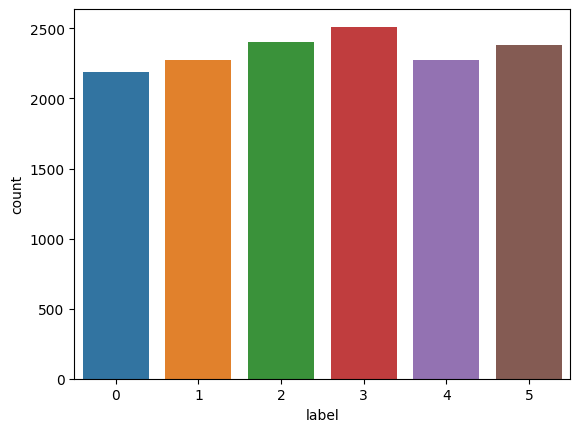

In [14]:
sns.countplot(data=train_df,x="label")

## Test Dataframe

In [15]:
# Directory path
test_data_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

# Mapping of folder names to labels
label_mapping = {
    'buildings': 0,
    'forest': 1,
    'glacier': 2,
    'mountain': 3,
    'sea': 4,
    'street': 5
}

# Initialize lists to store image paths and labels
all_paths = []
all_labels = []

# Iterate through folders and files
for folder_name in os.listdir(test_data_dir):
    folder_path = os.path.join(test_data_dir, folder_name)
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # Default to -1 if folder name is not in label_mapping
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            all_paths.append(file_path)
            all_labels.append(label)

# Create DataFrame
test_df = pd.DataFrame({'path': all_paths, 'label': all_labels})


test_df.head()


path  label
0  /kaggle/input/intel-image-classification/seg_t...      3
1  /kaggle/input/intel-image-classification/seg_t...      3
2  /kaggle/input/intel-image-classification/seg_t...      3
3  /kaggle/input/intel-image-classification/seg_t...      3
4  /kaggle/input/intel-image-classification/seg_t...      3

In [16]:
test_df.shape

(3000, 2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

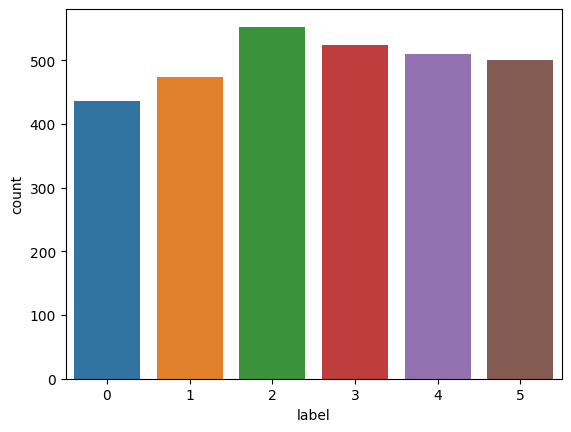

In [17]:
sns.countplot(data=test_df,x="label")

## Prediction Dataframe

In [18]:
# Directory path for prediction images
pred_data_dir = '/kaggle/input/intel-image-classification/seg_pred/seg_pred'
# Get paths to prediction images
pred_image_paths = [os.path.join(pred_data_dir, img) for img in os.listdir(pred_data_dir)]
pred_df = pd.DataFrame({'path': pred_image_paths})

pred_df.head()



path
0  /kaggle/input/intel-image-classification/seg_p...
1  /kaggle/input/intel-image-classification/seg_p...
2  /kaggle/input/intel-image-classification/seg_p...
3  /kaggle/input/intel-image-classification/seg_p...
4  /kaggle/input/intel-image-classification/seg_p...

## Concatenate the two Train and Test dataframe

In [19]:
# Concatenate the two dataframes
combined_df = pd.concat([train_df, test_df], ignore_index=True)

combined_df.head()

path  label
0  /kaggle/input/intel-image-classification/seg_t...      3
1  /kaggle/input/intel-image-classification/seg_t...      3
2  /kaggle/input/intel-image-classification/seg_t...      3
3  /kaggle/input/intel-image-classification/seg_t...      3
4  /kaggle/input/intel-image-classification/seg_t...      3

In [20]:
combined_df.shape

(17034, 2)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='label', ylabel='count'>

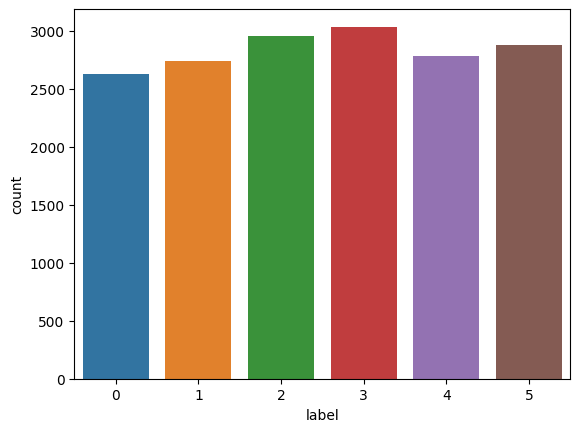

In [21]:
sns.countplot(data=combined_df,x="label")

In [22]:
# Convert numerical labels to strings
combined_df['label'] = combined_df['label'].astype(str)

In [23]:
# Split the data into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(combined_df, test_size=0.15, shuffle=True, random_state=42)

# Print the lengths of the resulting datasets
print("Training set length:", len(train_df))

#print("Validation set length:", len(val_df))
print("Testing set length:", len(test_df))

Training set length: 14478
Testing set length: 2556


In [24]:
# Perform 10-fold cross-validation on the training set
fold_train_dfs = []
fold_val_dfs = []

for i in range(10):
    fold_train, fold_val = train_test_split(train_df, test_size=0.15, random_state=i)
    fold_train_dfs.append(fold_train)
    fold_val_dfs.append(fold_val)

# Print the lengths of the fold datasets
for i in range(5):
    print("Fold", i+1)
    print("Training set length:", len(fold_train_dfs[i]))
    print("Validation set length:", len(fold_val_dfs[i]))

    
print("\n")
# Setting the test set as the final evaluation set
evaluation_set = test_df

# Print the length of the evaluation set
print("Evaluation set length:", len(evaluation_set))

Fold 1
Training set length: 12306
Validation set length: 2172
Fold 2
Training set length: 12306
Validation set length: 2172
Fold 3
Training set length: 12306
Validation set length: 2172
Fold 4
Training set length: 12306
Validation set length: 2172
Fold 5
Training set length: 12306
Validation set length: 2172


Evaluation set length: 2556


In [25]:
img_size = (150, 150)
batch_size = 32
num_classes = 6
epochs=10

In [32]:
# Create an ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
pred_datagen = ImageDataGenerator(rescale=1./255)

In [27]:
def cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = Adam(lr=1e-4) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

Fold 1
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 71s 154ms/step - loss: 1.0042 - accuracy: 0.6179 - val_loss: 0.7417 - val_accuracy: 0.7284 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 23s 58ms/step - loss: 0.6435 - accuracy: 0.7652 - val_loss: 0.5685 - val_accuracy: 0.7891 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 22s 57ms/step - loss: 0.4661 - accuracy: 0.8319 - val_loss: 0.5369 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 22s 56ms/step - loss: 0.3413 - accuracy: 0.8772 - val_loss: 0.5894 - val_accuracy: 0.8052 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 22s 57ms/step - loss: 0.2238 - accuracy: 0.

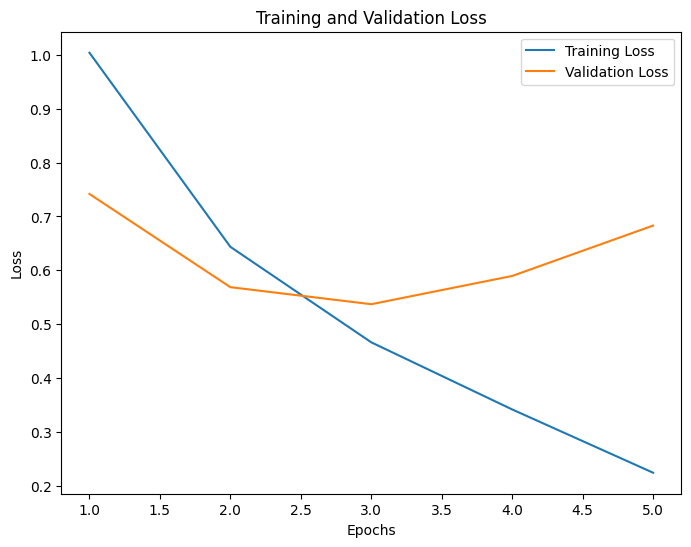

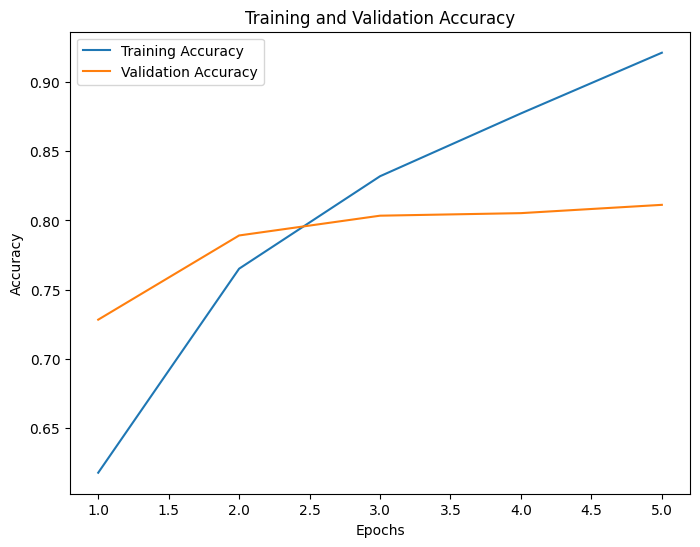

Fold 2
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 24s 58ms/step - loss: 0.9899 - accuracy: 0.6278 - val_loss: 0.7187 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 22s 57ms/step - loss: 0.6428 - accuracy: 0.7651 - val_loss: 0.5772 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 22s 58ms/step - loss: 0.4740 - accuracy: 0.8317 - val_loss: 0.5158 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 22s 57ms/step - loss: 0.3555 - accuracy: 0.8732 - val_loss: 0.5921 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 22s 57ms/step - loss: 0.2118 - accuracy: 0.9

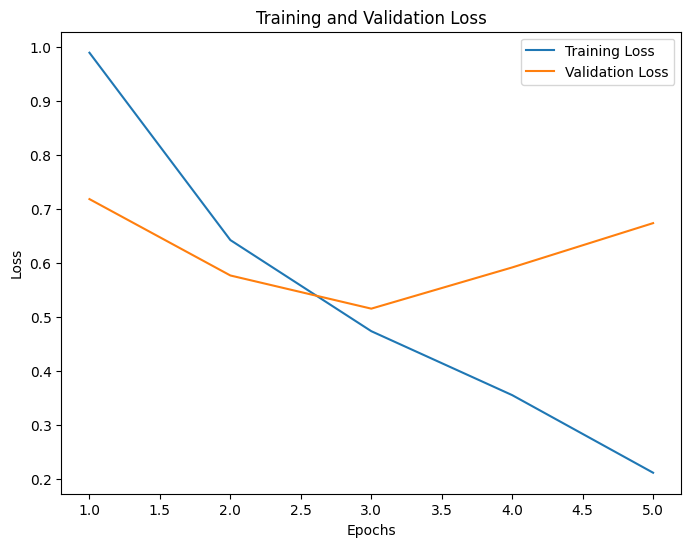

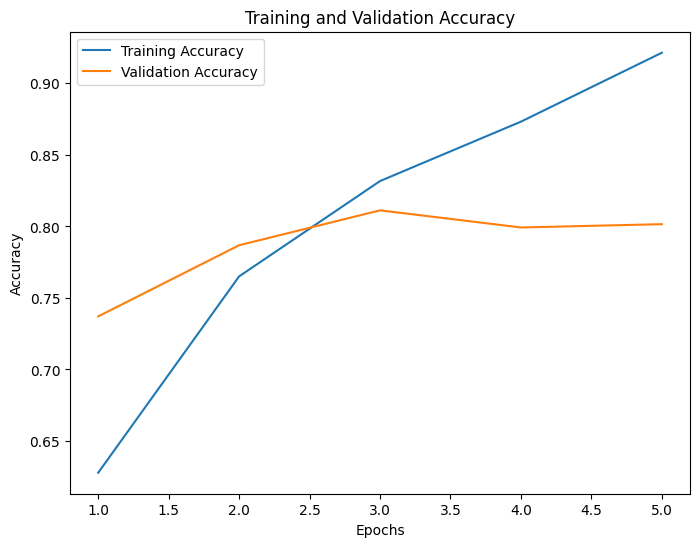

Fold 3
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 24s 58ms/step - loss: 0.9244 - accuracy: 0.6459 - val_loss: 0.6944 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 22s 56ms/step - loss: 0.5874 - accuracy: 0.7867 - val_loss: 0.5709 - val_accuracy: 0.7960 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 23s 60ms/step - loss: 0.4387 - accuracy: 0.8385 - val_loss: 0.5084 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 21s 55ms/step - loss: 0.2891 - accuracy: 0.8974 - val_loss: 0.6779 - val_accuracy: 0.7749 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 21s 54ms/step - loss: 0.1685 - accuracy: 0.9

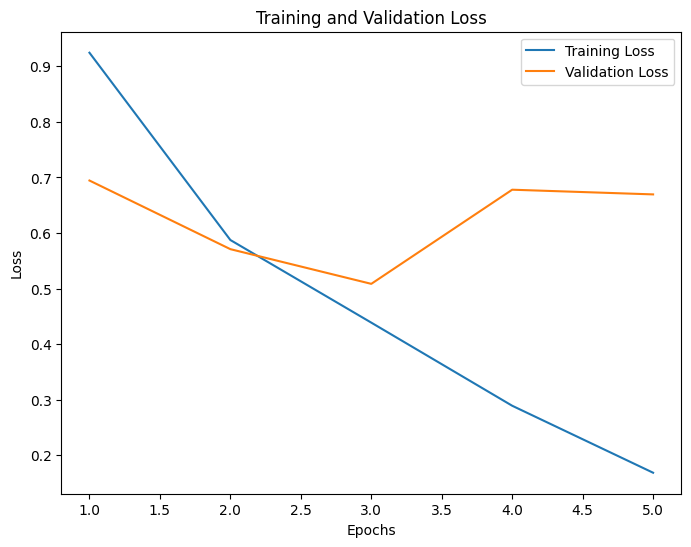

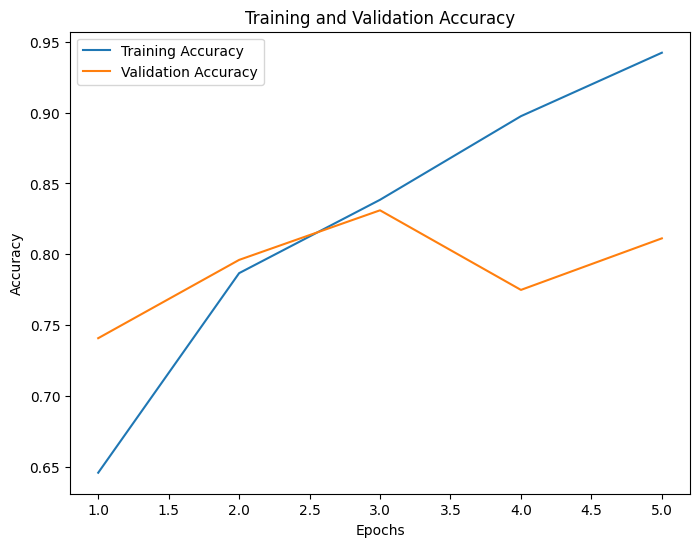

Fold 4
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 25s 58ms/step - loss: 0.9707 - accuracy: 0.6269 - val_loss: 0.7340 - val_accuracy: 0.7233 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 22s 57ms/step - loss: 0.6077 - accuracy: 0.7842 - val_loss: 0.6494 - val_accuracy: 0.7643 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 21s 55ms/step - loss: 0.4681 - accuracy: 0.8319 - val_loss: 0.5007 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 21s 53ms/step - loss: 0.3116 - accuracy: 0.8904 - val_loss: 0.5310 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 21s 54ms/step - loss: 0.1886 - accuracy: 0.9

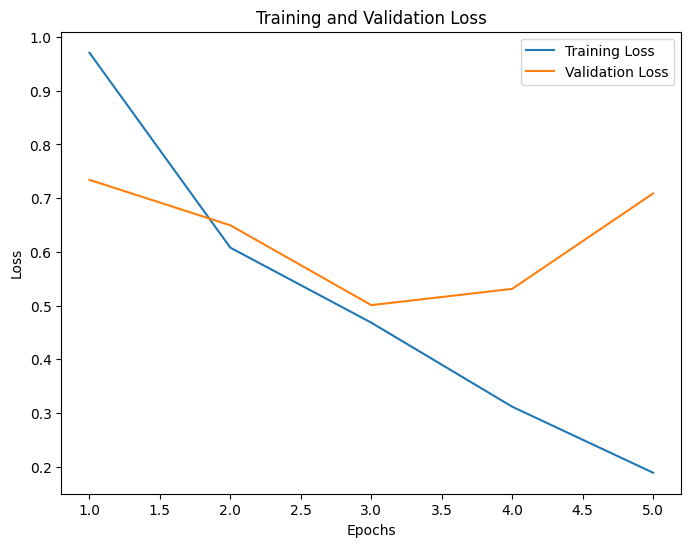

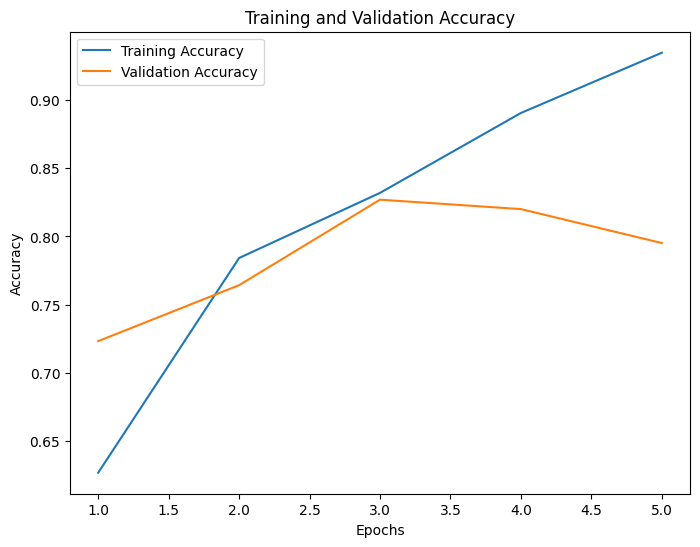

Fold 5
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 23s 56ms/step - loss: 0.9915 - accuracy: 0.6185 - val_loss: 0.6959 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 21s 55ms/step - loss: 0.6007 - accuracy: 0.7796 - val_loss: 0.5822 - val_accuracy: 0.7937 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 22s 56ms/step - loss: 0.4803 - accuracy: 0.8266 - val_loss: 0.5374 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 21s 55ms/step - loss: 0.3558 - accuracy: 0.8734 - val_loss: 0.6167 - val_accuracy: 0.7993 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 22s 56ms/step - loss: 0.2341 - accuracy: 0.9

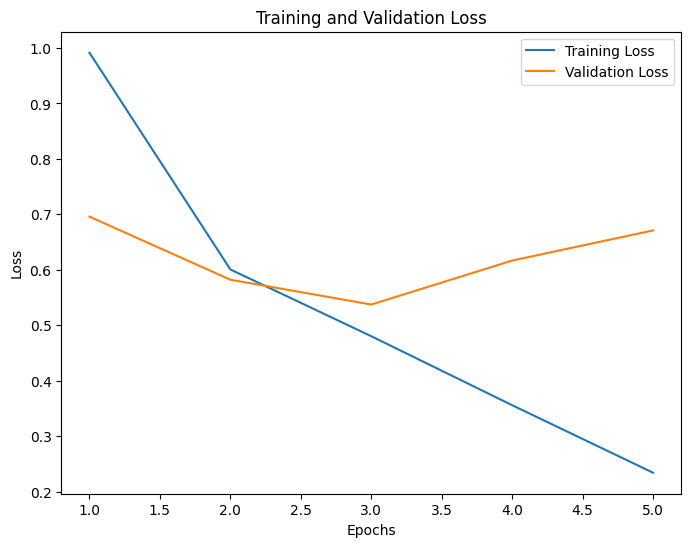

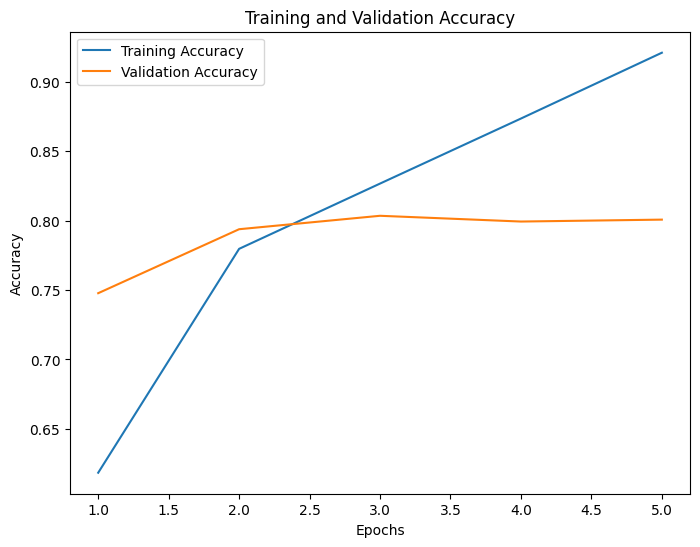

In [28]:

# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)
    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("val_generator classes", val_generator.class_indices)
    
    # Build and compile the model
    model = cnn_model()

    # Train the model

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr]  # Add callbacks
    )

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [29]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)


Average Training Loss: [0.5357791006565094, 0.5348128944635391, 0.48160383105278015, 0.5093424469232559, 0.5324911832809448]
Average Validation Loss: [0.6239144206047058, 0.6155914545059205, 0.6242096185684204, 0.6247544407844543, 0.6206687688827515]
Average Training Accuracy: [0.8026328563690186, 0.8038517832756042, 0.8221355557441712, 0.8135706067085267, 0.8037705063819885]
Average Validation Accuracy: [0.7874769806861878, 0.7872007250785827, 0.7907919049263, 0.7859116077423096, 0.7889502763748169]


In [30]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.5188058912754059
Mean Validation Loss: 0.6218277406692504
Mean Training Accuracy: 0.809192261695862
Mean Validation Accuracy: 0.7880662989616395


In [31]:
# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='sparse'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 2556 validated image filenames belonging to 6 classes.
evaluation_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
80/80 [==============================] - 14s 171ms/step - loss: 0.5141 - accuracy: 0.8185
Evaluation Loss: 0.5141299962997437
Evaluation Accuracy: 0.8184663653373718


### Evaluation Accuracy: 0.8184663653373718


80/80 [==============================] - 4s 46ms/step


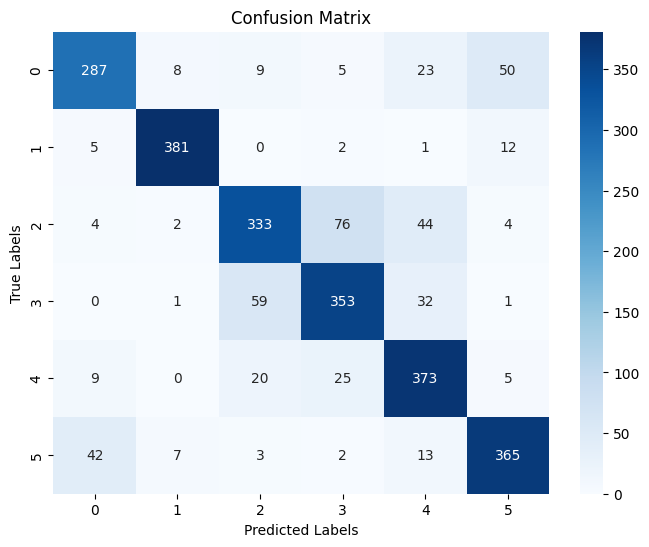

In [34]:
#metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the predicted labels
y_pred = model.predict(evaluation_generator).argmax(axis=1)

# Get the true labels
y_true = evaluation_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = list(evaluation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [37]:
# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       382
           1       0.95      0.95      0.95       401
           2       0.79      0.72      0.75       463
           3       0.76      0.79      0.78       446
           4       0.77      0.86      0.81       432
           5       0.84      0.84      0.84       432

    accuracy                           0.82      2556
   macro avg       0.82      0.82      0.82      2556
weighted avg       0.82      0.82      0.82      2556



## Predictions

In [33]:
# Create a generator for the prediction data
pred_generator = pred_datagen.flow_from_dataframe(
    dataframe=pred_df,
    x_col="path",
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False  
)

# Make predictions using the trained model
predictions = model.predict(pred_generator)


predicted_labels = predictions.argmax(axis=1)

# Create a DataFrame with paths and predicted labels
result_df = pd.DataFrame({'path': pred_df['path'], 'predicted_label': predicted_labels})
result_df.head()

Found 7301 validated image filenames.
229/229 [==============================] - 55s 240ms/step


path  predicted_label
0  /kaggle/input/intel-image-classification/seg_p...                4
1  /kaggle/input/intel-image-classification/seg_p...                5
2  /kaggle/input/intel-image-classification/seg_p...                3
3  /kaggle/input/intel-image-classification/seg_p...                0
4  /kaggle/input/intel-image-classification/seg_p...                3

## Model using Transfer Learning

Fold 1
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 122s 237ms/step - loss: 0.6009 - accuracy: 0.8346 - val_loss: 3318.4854 - val_accuracy: 0.3131 - lr: 0.0010
Epoch 2/10
385/385 [==============================] - 86s 224ms/step - loss: 0.4805 - accuracy: 0.8600 - val_loss: 0.3602 - val_accuracy: 0.8867 - lr: 0.0010
Epoch 3/10
385/385 [==============================] - 86s 224ms/step - loss: 0.3296 - accuracy: 0.9048 - val_loss: 30.5957 - val_accuracy: 0.2127 - lr: 0.0010
Epoch 4/10
385/385 [==============================] - 86s 223ms/step - loss: 0.5864 - accuracy: 0.8491 - val_loss: 15.6742 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 5/10
385/385 [==============================] - 86s 224ms/step - loss: 0.2587 - ac

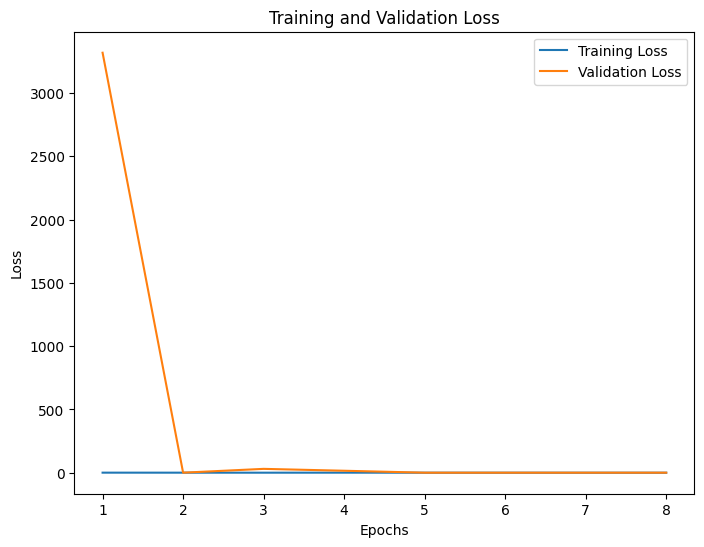

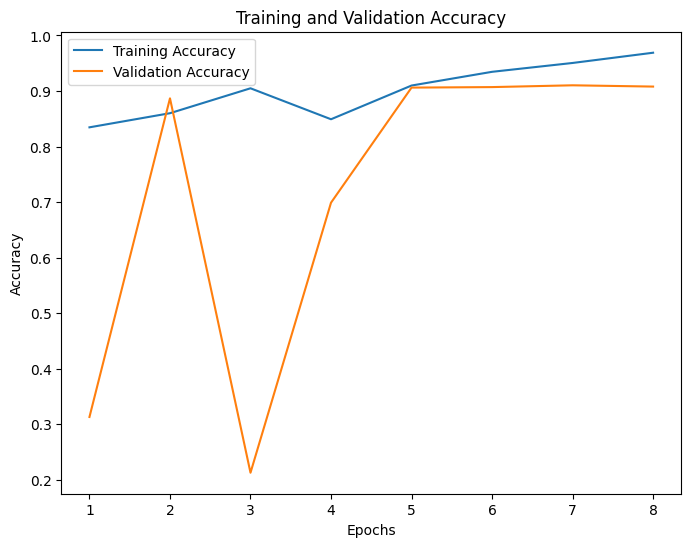

Fold 2
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 87s 225ms/step - loss: 0.1954 - accuracy: 0.9344 - val_loss: 0.4856 - val_accuracy: 0.9259 - lr: 4.0000e-05
Epoch 2/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1758 - accuracy: 0.9399 - val_loss: 0.3081 - val_accuracy: 0.9392 - lr: 4.0000e-05
Epoch 3/10
385/385 [==============================] - 86s 223ms/step - loss: 0.1581 - accuracy: 0.9426 - val_loss: 0.5690 - val_accuracy: 0.9305 - lr: 4.0000e-05
Epoch 4/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1385 - accuracy: 0.9507 - val_loss: 0.3339 - val_accuracy: 0.9378 - lr: 4.0000e-05
Epoch 5/10
385/385 [==============================] - 86s 224ms/step - loss: 0

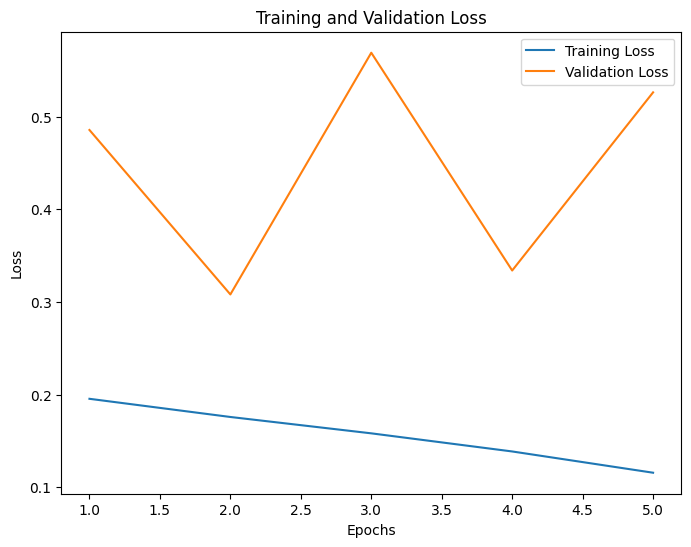

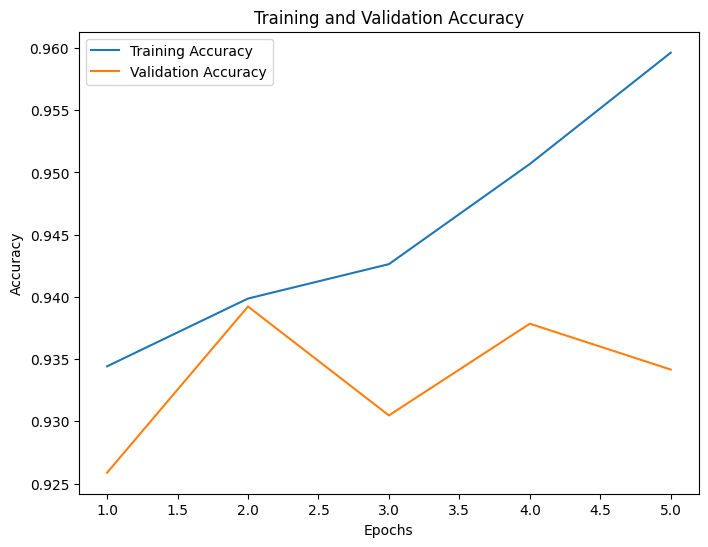

Fold 3
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 87s 224ms/step - loss: 0.1631 - accuracy: 0.9438 - val_loss: 0.2298 - val_accuracy: 0.9438 - lr: 8.0000e-06
Epoch 2/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1565 - accuracy: 0.9469 - val_loss: 0.2190 - val_accuracy: 0.9457 - lr: 8.0000e-06
Epoch 3/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1493 - accuracy: 0.9480 - val_loss: 0.2395 - val_accuracy: 0.9452 - lr: 8.0000e-06
Epoch 4/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1408 - accuracy: 0.9524 - val_loss: 0.2226 - val_accuracy: 0.9457 - lr: 8.0000e-06
Epoch 5/10
385/385 [==============================] - 86s 224ms/step - loss: 0

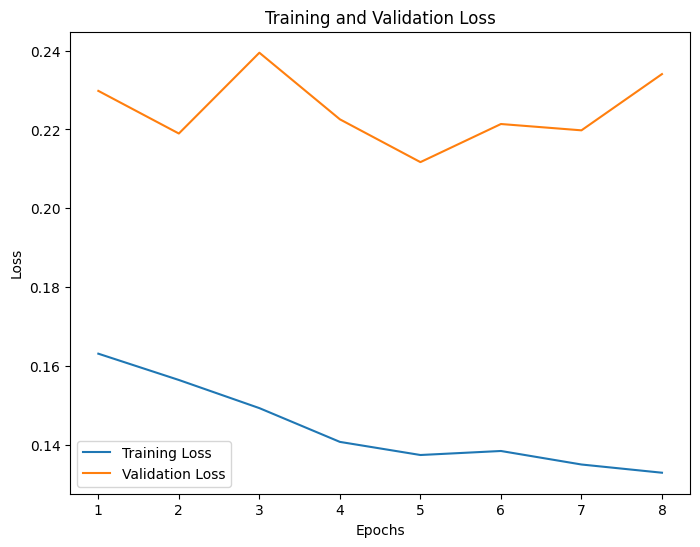

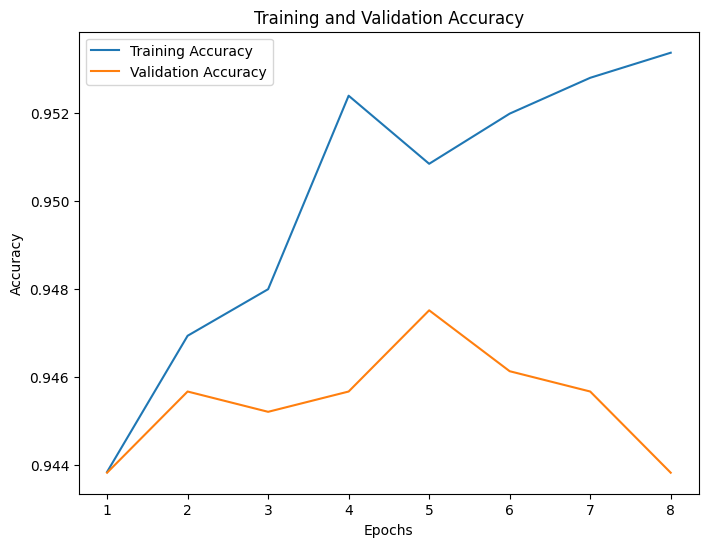

Fold 4
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1394 - accuracy: 0.9514 - val_loss: 0.2375 - val_accuracy: 0.9507 - lr: 1.0000e-06
Epoch 2/10
385/385 [==============================] - 86s 223ms/step - loss: 0.1394 - accuracy: 0.9516 - val_loss: 0.2436 - val_accuracy: 0.9503 - lr: 1.0000e-06
Epoch 3/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1345 - accuracy: 0.9525 - val_loss: 0.2376 - val_accuracy: 0.9521 - lr: 1.0000e-06
Epoch 4/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1368 - accuracy: 0.9534 - val_loss: 0.2018 - val_accuracy: 0.9553 - lr: 1.0000e-06
Epoch 5/10
385/385 [==============================] - 86s 223ms/step - loss: 0

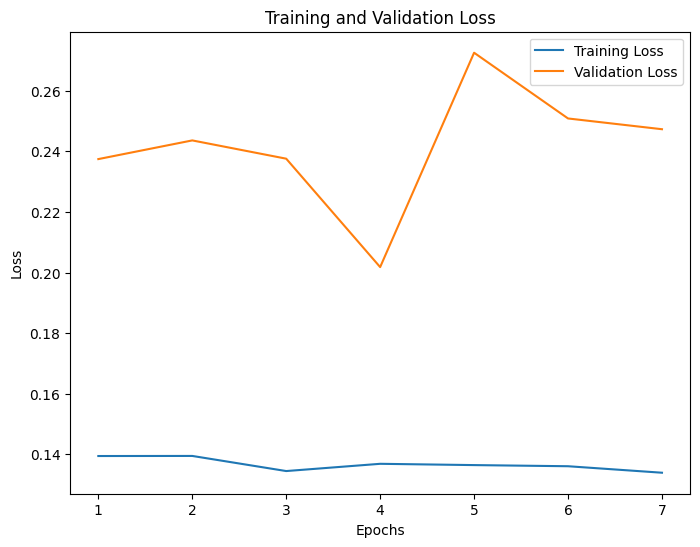

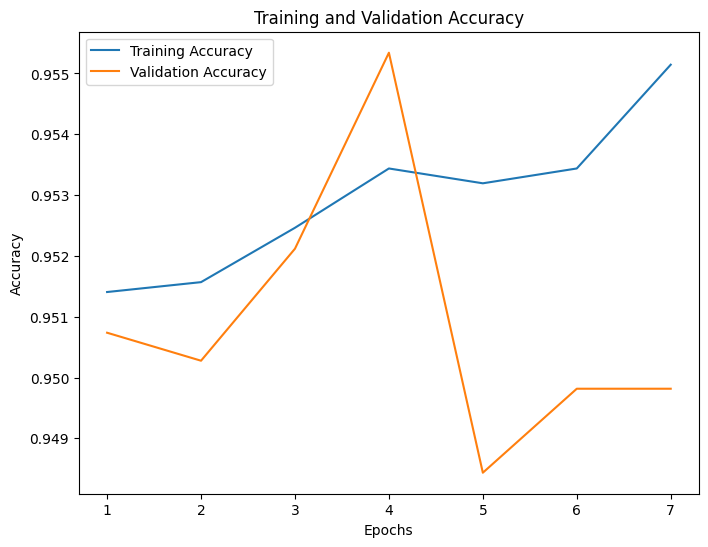

Fold 5
Found 12306 validated image filenames belonging to 6 classes.
train_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Found 2172 validated image filenames belonging to 6 classes.
val_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
Epoch 1/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1388 - accuracy: 0.9527 - val_loss: 0.2578 - val_accuracy: 0.9563 - lr: 1.0000e-06
Epoch 2/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1391 - accuracy: 0.9531 - val_loss: 0.2252 - val_accuracy: 0.9581 - lr: 1.0000e-06
Epoch 3/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1379 - accuracy: 0.9529 - val_loss: 0.2007 - val_accuracy: 0.9590 - lr: 1.0000e-06
Epoch 4/10
385/385 [==============================] - 86s 224ms/step - loss: 0.1377 - accuracy: 0.9516 - val_loss: 0.2216 - val_accuracy: 0.9581 - lr: 1.0000e-06
Epoch 5/10
385/385 [==============================] - 86s 223ms/step - loss: 0

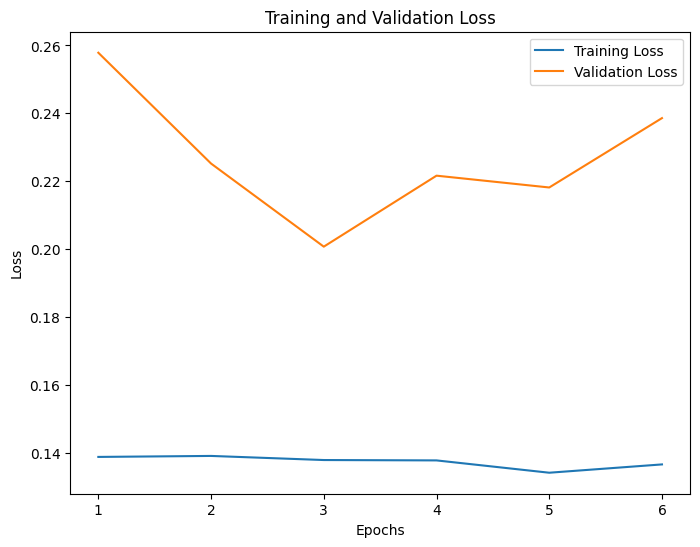

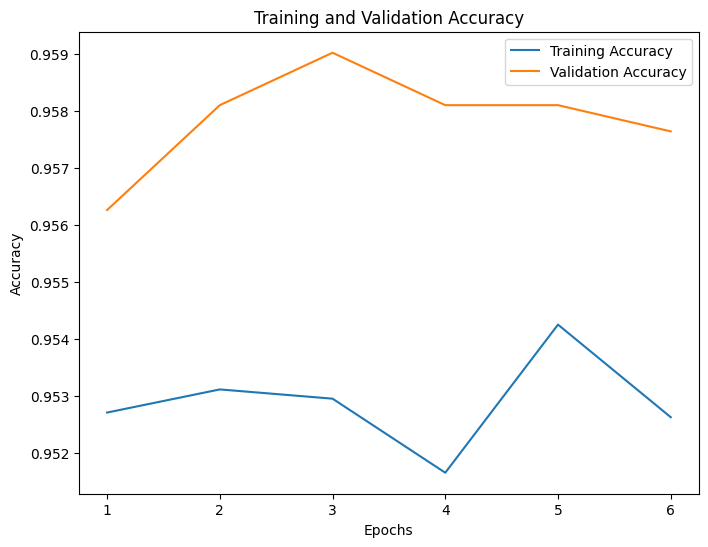

In [44]:
# Define the input shape
input_shape = (150,150,3)

# Load the pre-trained Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)
# Add a global average pooling layer, BatchNormalization, and a dense output layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Add BatchNormalization
output = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a lower learning rate 0.0001
optimizer = Adam(lr=1e-4)  
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Number of epochs and batch size
epochs = 10
batch_size = 32

# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)
    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("val_generator classes", val_generator.class_indices)

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr]  # Add callbacks
    )

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [45]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)


Average Training Loss: [0.334381939843297, 0.1566614627838135, 0.14421562664210796, 0.13664584713322775, 0.13735010474920273]
Average Validation Loss: [420.82157177105546, 0.4445748209953308, 0.22470787167549133, 0.24160348730427877, 0.22701883564392725]
Average Training Accuracy: [0.9015114605426788, 0.9454412579536438, 0.9500142261385918, 0.9529497708593097, 0.9528820614020029]
Average Validation Accuracy: [0.7178291883319616, 0.9335174918174743, 0.9454419910907745, 0.9509339588029044, 0.9578729271888733]


In [46]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.18185099623032977
Mean Validation Loss: 84.3918953573349
Mean Training Accuracy: 0.9405597553792454
Mean Validation Accuracy: 0.9011191114463977


In [47]:
# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=evaluation_set,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='sparse'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 2556 validated image filenames belonging to 6 classes.
evaluation_generator classes {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5}
80/80 [==============================] - 5s 61ms/step - loss: 0.4516 - accuracy: 0.9026
Evaluation Loss: 0.45161521434783936
Evaluation Accuracy: 0.9025821685791016


80/80 [==============================] - 5s 57ms/step


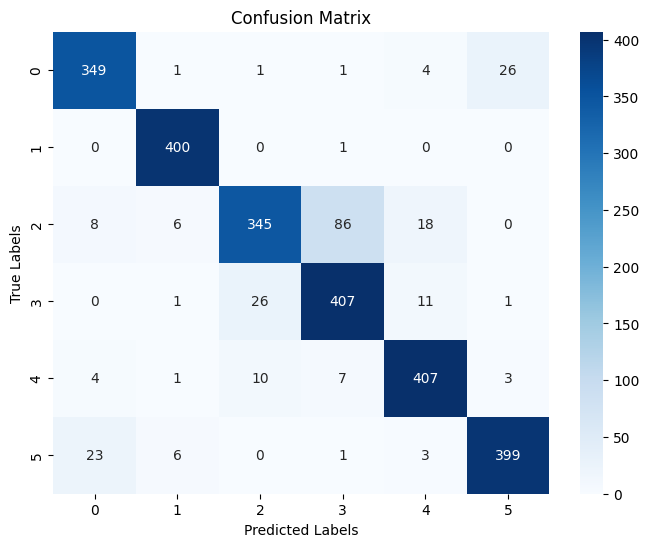

In [48]:
#metrics

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the predicted labels
y_pred = model.predict(evaluation_generator).argmax(axis=1)

# Get the true labels
y_true = evaluation_generator.classes

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
class_labels = list(evaluation_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [49]:
# Print classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

           0       0.91      0.91      0.91       382
           1       0.96      1.00      0.98       401
           2       0.90      0.75      0.82       463
           3       0.81      0.91      0.86       446
           4       0.92      0.94      0.93       432
           5       0.93      0.92      0.93       432

    accuracy                           0.90      2556
   macro avg       0.91      0.91      0.90      2556
weighted avg       0.90      0.90      0.90      2556



### Predictions

In [50]:
# Create a generator for the prediction data
pred_generator = pred_datagen.flow_from_dataframe(
    dataframe=pred_df,
    x_col="path",
    target_size=img_size,
    batch_size=batch_size,
    class_mode=None,  
    shuffle=False  
)

# Make predictions using the trained model
predictions = model.predict(pred_generator)


predicted_labels = predictions.argmax(axis=1)

# Create a DataFrame with paths and predicted labels
result_df = pd.DataFrame({'path': pred_df['path'], 'predicted_label': predicted_labels})
result_df.head()

Found 7301 validated image filenames.
229/229 [==============================] - 15s 60ms/step


path  predicted_label
0  /kaggle/input/intel-image-classification/seg_p...                4
1  /kaggle/input/intel-image-classification/seg_p...                5
2  /kaggle/input/intel-image-classification/seg_p...                3
3  /kaggle/input/intel-image-classification/seg_p...                0
4  /kaggle/input/intel-image-classification/seg_p...                3

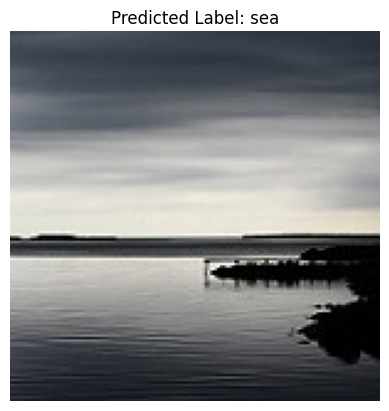

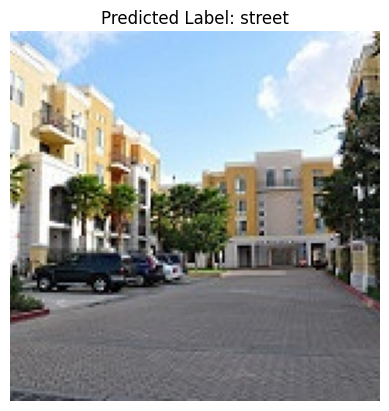

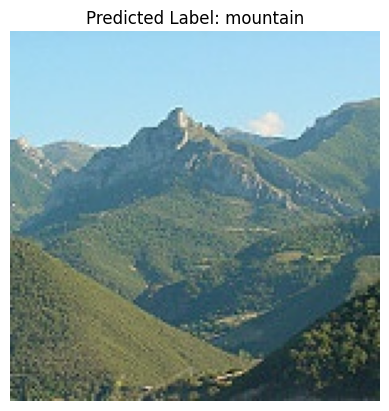

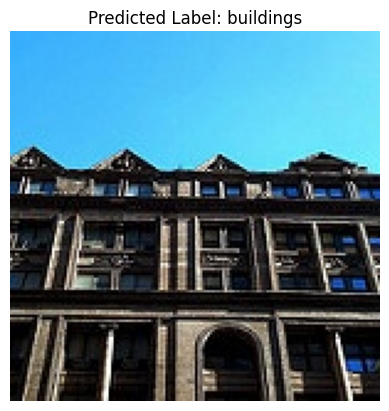

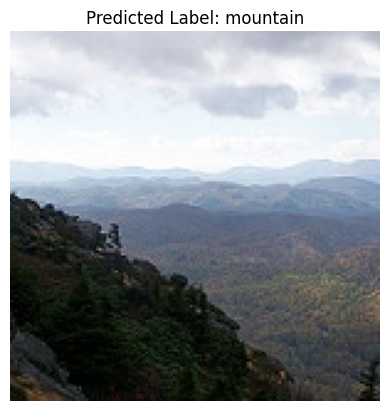

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


label_names = {
    0: 'buildings',
    1: 'forest',
    2: 'glacier',
    3: 'mountain',
    4: 'sea',
    5: 'street'
}

num_images_to_display = 5

for i in range(min(num_images_to_display, len(result_df))):
    img_path = result_df['path'].iloc[i]
    img_label_numeric = result_df['predicted_label'].iloc[i]

    
    img_label_name = label_names.get(img_label_numeric, 'Unknown')

    # Load and display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f'Predicted Label: {img_label_name}')
    plt.axis('off')
    plt.show()


## Thank you!